# 2D Annotations of Molecules 

## Introduction
The goal of this project is to render a 2 dimensional molecular drawing with annotations detailing a specific feature per atom. 

This example 

## Dependencies
1. IOData
2. Numpy
3. RDKit
5. CHEMML 
6. Pandas
7. Glob 
8. OS 


In [2]:
# import required libraries
from iodata import load_one, dump_one

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Atom
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import DrawingOptions

from IPython.display import Image

from chemml.chem import Molecule

import pandas as pd
import glob
import os

## Manipulation of Input and Extraction of Charges 

We first want to open our file using IOData, designated `loadInput`, from then we can extract informations related to the `.fchk` file using IOData to annotate our molecule

In [6]:
inputName = 'acrolein_q+0.fchk'
loadInput = load_one(inputName) 

xyzName = 'acrolein_q+0.xyz'
pdbName = 'acrolein_q+0.pdb'
molName = xyzName[:-4]
imageName = f"{molName}.png" 

print("Molecule Name : ")
print(molName)
print(" ")

dump_one(loadInput,pdbName)
dump_one(loadInput, xyzName)
espCharges = loadInput.atcharges['esp'][:]

Molecule Name : 
acrolein_q+0
 


## Manipulate Molecule to Create MOL Object
We need to dump our IOData loaded molecule into an `.xyz` file, which can then be parsed using `CHEMML`, to create a data table containing basic information such as filename, XYZ Cartesian Coordinates, and the SMILES equivalent of the molecule.

We can then extract the SMILES string and convert into MOL Format for processing by RDKit. 

We can then use a series of commands `drawMolecule.*` to generate a visualization of our molecule. 

The below image is RDKit visualization without annotations. 

<chemml.chem.Molecule(
        rdkit_molecule : None,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7fd21472f5d0>,
        creator        : ('XYZ', 'dichloropyridine26_q+0.xyz'),
        smiles         : None,
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (11, 3), atomic_numbers: (11, 1), atomic_symbols: (11, 1))>)>
Clc1nc(Cl)ccc1	dichloropyridine26_q+0 ub3lyp/cc-pvtz sp-stable

[<chemml.chem.Molecule(
        rdkit_molecule : <rdkit.Chem.rdchem.Mol object at 0x7fd214707990>,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7fd21472f750>,
        creator        : ('XYZ', 'acrolein_q+0.xyz'),
        smiles         : 'C=CC=O',
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (8, 3), atomic_numbers: (8, 1), atomic_symbols: (8, 1))>)>]
 

               Name  SMILES
0  acrolein_q+0.xyz  C=CC=O
 
Our Molecule in SMILES format: 
C=CC=O
 
-0.473096529
-0

Exception ignored in: <function LineIterator.__del__ at 0x7fd2980ec440>
Traceback (most recent call last):
  File "/home/woodn/.conda/envs/chemml_env/lib/python3.7/site-packages/iodata/utils.py", line 80, in __del__
    self.f.close()
AttributeError: 'LineIterator' object has no attribute 'f'


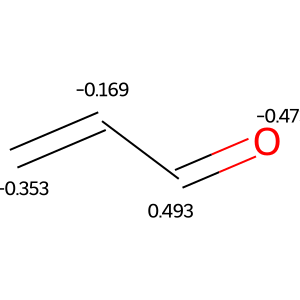

In [9]:
xyz_files = glob.glob(xyzName)
mol = Molecule('dichloropyridine26_q+0.xyz', 'xyz')
print(mol)
print(mol.visualize())

# make a list of ChemML Molecule object instances based on the names of the xyz files from xyz_files
molecule_list = [Molecule(xyzName, input_type='xyz') for file in xyz_files]

# alter the ChemML Molecule object instances of molecule_list so that their SMILES codes can be recognzied by RDKit
for molecule in molecule_list:
    molecule.to_smiles()

print(molecule_list)

table = pd.DataFrame(data={'Name':xyzName,  
                         'SMILES':[molecule.smiles for molecule in molecule_list]}, 
                   columns=['Name','SMILES'])

print(" ")
print("")
print(table)

print(" ")
smiles = table.iloc[0,1]
print("Our Molecule in SMILES format: ")
print(smiles)
print(" ")


chem = Chem.MolFromPDBFile(pdbName, sanitize=True)
template = Chem.MolFromSmiles(smiles)
AllChem.Compute2DCoords(chem)
tempMol = AllChem.AssignBondOrdersFromTemplate(template,chem)

def imageMolecule(chem,imageName):
    """
    This function consolidates all calls done to generate the desired image
    """
    
    drawMolecule = rdMolDraw2D.MolDraw2DCairo(300, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawMolecule, chem)
    drawMolecule.drawOptions().addStereoAnnotation = True
    
    for i, atom in enumerate(tempMol.GetAtoms()):
        atom.SetProp("atomNote", f"{np.round(float(espCharges[i]),3)}")
        print(espCharges[i])
    
    Chem.Draw.MolToFile(tempMol,imageName)


imageMolecule(tempMol,imageName)

Image(imageName)